In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation

In [61]:
def create_lattice(Lx,Ly):
    lattice = np.random.choice([-1,1], size = Lx*Ly).reshape(Ly,Lx)
    neighs = []
    for i in range(Lx*Ly):
        mj = i // Lx
        mi = i - mj*Lx
        neighs.append([[(mj-1)%Ly,mi],
                      [(mj+1)%Ly,mi],
                      [mj,(mi+1)%Lx],
                      [mj,(mi-1)%Lx]])

    return lattice, neighs

In [62]:
def find_droplet(spin, lattice, neighs, actspins, checkedspins, Beta, J, Lx, Ly):
    newly_added = []
    
    i = spin[0]*Lx+spin[1]
    spin_val = lattice[spin[0],spin[1]]
    for nspin in neighs[i]:
        nspin_val = lattice[nspin[0],nspin[1]]
        if (nspin_val == spin_val) and ( nspin not in checkedspins ) : #if the spin is in the same cluster and it was not already checked
            if np.random.random()< (1-np.exp(-2*Beta*J)): #we generate a random number and add the spin to the others via this proability
                newly_added.append(nspin)
                actspins.append(nspin)
            else:
                pass
            checkedspins.append(nspin)
    
    #now we have added all the neighbours with a probabilistic weight
    #now we go through all those neighbours that we have added recently
    #and carry out ths previous procedure for those as well
    
    for new_spin in newly_added:
        actspins,checkedspins = find_droplet(spin = new_spin, lattice = lattice, neighs = neighs,
                                             actspins = actspins, checkedspins = checkedspins, Beta = Beta, J = J,
                                             Lx = Lx, Ly = Ly)
    return actspins,checkedspins

In [63]:
def update_lattice(lattice,actspins):
    #flip all the active spins
    for spin in actspins:
        lattice[spin[0],spin[1]] *= -1
    
    return lattice

In [64]:
def single_spin_energy(spin_num, lattice, neighs, J, Lx, Ly):
    single_E = 0
    
    #coordinates of the single spin
    mj = spin_num // Lx
    mi = spin_num - mj*Lx
    
    #value of the spin
    spin_val = lattice[mj,mi]
    
    #iterate through the neighbours
    for neigh in neighs[spin_num]:
        
        #add the interaction energy between the spins to the single spin energy 
        single_E += -1*J*lattice[neigh[0],neigh[1]]
    single_E *= spin_val
    
    #return the single particle interaction energy
    return single_E

In [65]:
def E0(lattice, neighs, J, Lx, Ly):
    #calculate the initial energy of the whole lattice
    
    #calculate the total energy
    E = 0
    
    #iterate through all the spins
    for i in range(Lx*Ly):
        #calculate the single spin energies 
        E += single_spin_energy(spin_num = i, lattice = lattice, neighs = neighs, J = J, Lx = Lx, Ly = Ly)
        
    return E/2 #take into account the overcounting of the bonds between the spins

In [66]:
def droplet_energy(lattice, actspins, neighs, J, Lx, Ly):
    #we dont need to calculate the total energy of the system but only the energy at those points where the spins have been flipped
    #what we can do is that we can go though the active spins that we will flip and calculate the interaction energy of those spins
    #before and after the flip
    #the new energy of the system will be E_new = E_initial - E_before + E_after 
    
    E_droplet = 0
    
    for spin in actspins: 
        spin_num = spin[0]*Lx+spin[1]
        E_droplet += single_spin_energy(spin_num = spin_num, lattice = lattice, neighs = neighs, J = J, Lx = Lx, Ly = Ly)
                                        
    return E_droplet

In [67]:
def wolff_algorithm(lattice, neighs, Beta, J, Lx, Ly, itnum, collect_lattice = True):
    E_initial = E0(lattice = lattice, neighs = neighs, J = J, Lx = Lx, Ly = Ly)
    
    Es = [E_initial]
    
    if collect_lattice:
        lat_container = [lattice.copy()]
    else:
        pass
    
    #now do the simulation for many iterations 
    for i in range(itnum):
        #in every iteration we first need to find a random spin and create an ising droplet around that spin
        #this random spin will be the first active spin in the system
        random_spin = [np.random.randint(Ly), np.random.randint(Lx)]
        
        #add the random spin to the list of randacitve spin and to the list of the checked spins
        actspins = [random_spin]
        checkedspins = [random_spin]
        
        #find the droplet of that given random spin
        actspins,checkedspins = find_droplet(spin = random_spin, lattice = lattice, neighs = neighs, actspins = actspins, checkedspins = checkedspins,
                                            Beta = Beta, J = J, Lx = Lx, Ly = Ly)
        
        #now we calculate the droplet_energy of the active spins before flipping the active spins
        Edroplet_before = droplet_energy(lattice = lattice, actspins = actspins, neighs = neighs, J = J, Lx = Lx, Ly = Ly)
        
        #now update the lattice based on the active spins 
        lattice = update_lattice(lattice = lattice, actspins = actspins)
        
        #now calculate the droplet energy of the system after the spins have been flipped
        Edroplet_after = droplet_energy(lattice = lattice, actspins = actspins, neighs = neighs, J = J, Lx = Lx, Ly = Ly)

        #update the energy of the system
        E_new = Es[-1] - Edroplet_before + Edroplet_after
        Es.append(E_new)
        
        if collect_lattice:
            lat_container.append(lattice.copy())        
        else:
            pass
    if collect_lattice:
        #return the energies of the system and the lattices
        return Es, lat_container
    else:
        return Es

In [68]:
Lx = 40
Ly = 40
J = 1
Beta = 0.45

initial_lattice, neighs = create_lattice(Lx = Lx, Ly = Ly)

In [69]:
Es, latcont = wolff_algorithm(lattice = initial_lattice.copy(), neighs = neighs, Beta = Beta, J = J,
                             Lx = Lx, Ly = Ly, itnum = 1500)

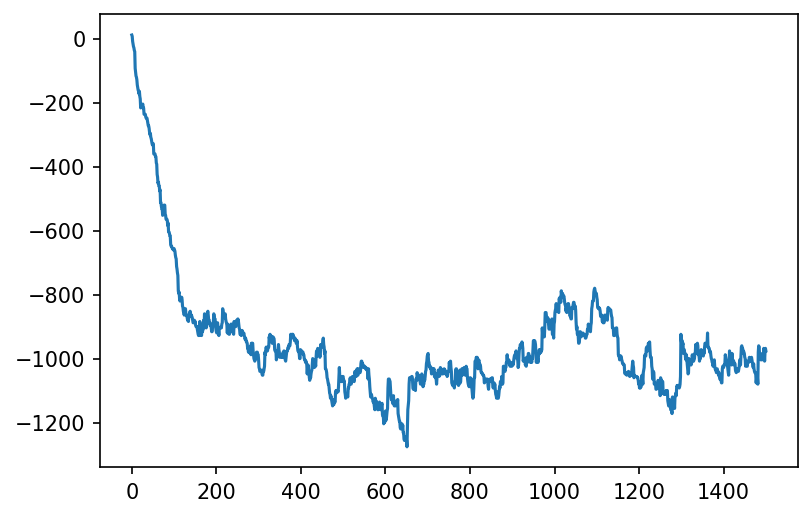

In [70]:
plt.plot(Es)

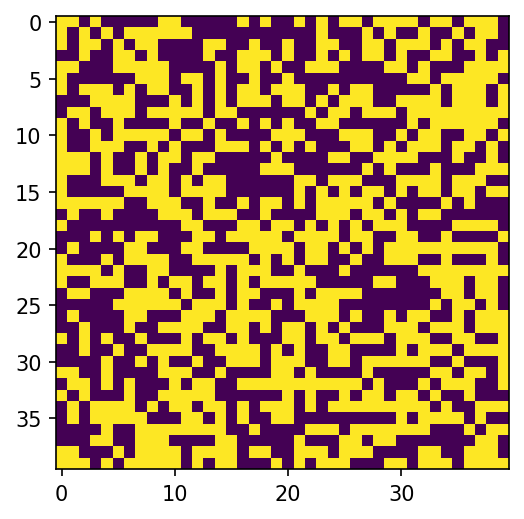

In [71]:
plt.imshow(latcont[0])

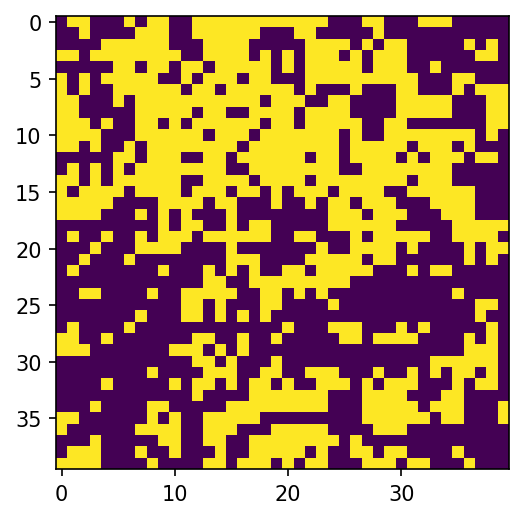

In [72]:
plt.imshow(latcont[-1])

In [124]:
def anim(latcont):
    plt.rcParams["animation.html"] = "jshtml"
    plt.rcParams['figure.dpi'] = 100  
    plt.ioff()
    fig, ax = plt.subplots()

    def animate(t):
        plt.imshow(latcont[10*t])

    d = matplotlib.animation.FuncAnimation(fig, animate, frames=15)
    return d

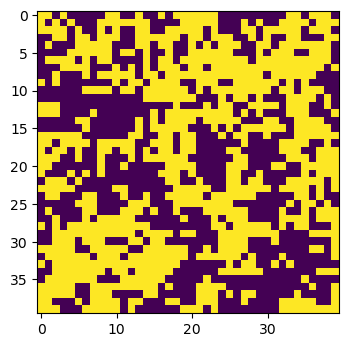

In [125]:
anim(latcont)

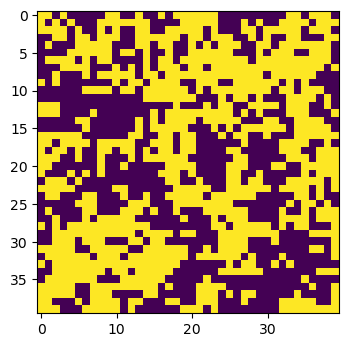

In [92]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.imshow(latcont[10*t])
    
matplotlib.animation.FuncAnimation(fig, animate, frames=15)

In [93]:
np.var(Es[700:])

6410.191305811555

In [94]:
def energy_fluctuations(Betas, J, Lx, Ly, itnum):
    
    initial_lattice, neighs = create_lattice(Lx = Lx, Ly = Ly)
    
    energy_flucts = []
    
    for Beta in Betas:
        Es = wolff_algorithm(lattice = initial_lattice.copy(), neighs = neighs, Beta = Beta, J = J,
                                 Lx = Lx, Ly = Ly, itnum = itnum, collect_lattice = False)
        energy_flucts.append(np.var(Es[int(itnum*0.3):]))
        
    return np.array(energy_flucts)

In [105]:
def ensemble_av(Betas, J, Lx, Ly, itnum, ens_num):
    initial_lattice, neighs = create_lattice(Lx = Lx, Ly = Ly)
    
    energy_flucts = []    
    
    for Beta in Betas:
        E_var = 0
        for i in range(ens_num):
            Es = wolff_algorithm(lattice = initial_lattice.copy(), neighs = neighs, Beta = Beta, J = J,
                                 Lx = Lx, Ly = Ly, itnum = itnum, collect_lattice = False)
            E_var += np.var(Es[int(itnum*0.3):]) / ens_num
        
        energy_flucts.append(E_var)
        
    return np.array(energy_flucts)

In [106]:
Betas = np.linspace(0.4,0.48,10)

In [108]:
Ef = energy_fluctuations(Betas = Betas, J = J, Lx = Lx, Ly = Ly, itnum = 3000)

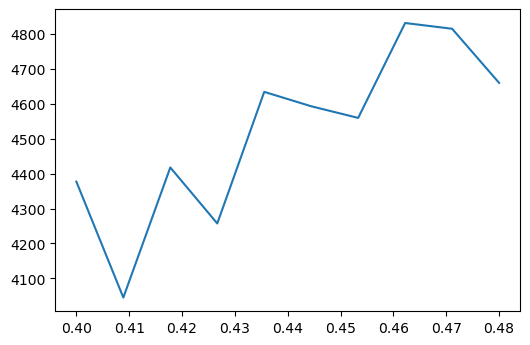

In [111]:
plt.plot(Betas, Ef)

In [113]:
Ef = ensemble_av(Betas = Betas, J = J, Lx = Lx, Ly = Ly, itnum = 3000, ens_num = 100)

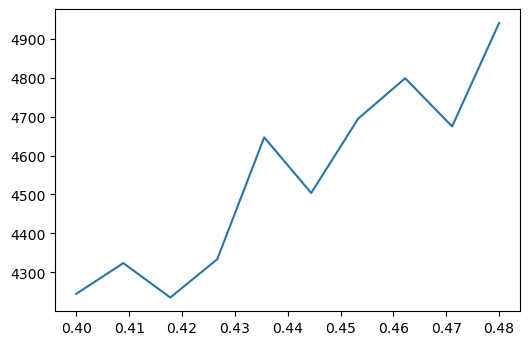

In [114]:
plt.plot(Betas, Ef)